# Projet: Facebook BaBi tasks
Notebook de la semaine du 30/01
Par Thierry Loesch et Bryce TIchit

Nous avons donc choisi le facebook BaBi tasks comme projet pour ce TER, le but de celui-ci étant de pouvoir raisonner sur un texte qui raconte une histoire et ainsi de pouvoir répondre à une question sur cette même histoire.

Exemple:
1 Mary moved to the bathroom.

2 John went to the hallway.

3 Where is Mary?        bathroom        1


Dans cet échantillon d'apprentissage on a une histoire puis une question (where is mary) à laquelle on répond par "bathroom" car il s'agit de l'endroit ou se trouve mary. Chaque phrase a son id dans l'histoire ainsi que la question, l'id qui se trouve après la réponse correspond à la phrase qui justifie cette réponse.

Nous commencerons par examiner les données, par les caractériser puis nous proposerons des solutions possibles. Les BaBi tasks sont au nombre de 20, avec un palier de difficulté supplémentaire par task. En effet plus on avance plus les réponses sont "compliquées" à obtenir et nécessite de raisonner sur plusieurs phrases en même temps. Pour ce notebook nous nous cantonnerons à la première task qui ne nécessite que d'une phrase par question.


In [2]:
"""
Le code suivant permet de récupérer et parser les données.
Source: https://github.com/fchollet/keras/blob/master/examples/babi_rnn.py
Note: Nous écrirons notre propre parser par la suite, nous avons repris celui donné en exemple afin de gagner
du temps pour ce notebook
"""

from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.utils.data_utils import get_file


def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories, and then convert the sentences into a single story.
    If max_length is supplied, any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

In [20]:
"""
Récupération des données et parsing
Le code provient de https://github.com/fchollet/keras/blob/master/examples/babi_rnn.py
"""

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

tar = tarfile.open(path)
challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
#challenge = 'tasks_1-20_v1-2/en/qa19_path-finding_{}.txt'

train = get_stories(tar.extractfile(challenge.format('train')))
test = get_stories(tar.extractfile(challenge.format('test')))
vocab = sorted(reduce(lambda x, y: x | y, (set(story + q + [answer]) for story, q, answer in train + test)))



    
    

    

/home/bryce/anaconda3/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [69]:
def uniq(l):
    ret = set()
    for el in l:
        ret.add(el)
    return list(ret)

flatten = lambda data: reduce(lambda x, y: x + y, data)
caracteres = uniq(flatten(map(list,vocab)))
sentences_from_stories = list(map(lambda d : d[0],train+test))

distribution = dict()
for s in sentences_from_stories:
    len_s = len(s)
    if len_s in distribution.keys():
        distribution[len_s] +=1
    else:
        distribution[len_s] = 1
        
for i in range(100):
    if i not in distribution.keys():
        distribution[i]=0
    

    

print("Taille du vocabulaire: {}".format(len(vocab)))
print("Nombre de caractères: {}".format(len(caracteres)))
print("Nombre de stories (apprentissage) : {}".format(len(test)))
print("Nombre de stories (test) : {}".format(len(test)))



Taille du vocabulaire: 21
Nombre de caractères: 29
Nombre de stories (apprentissage) : 1000
Nombre de stories (test) : 1000


On voit que le vocabulaire est plutôt petit, en effet les exemples sont assez repétitifs et utilisent peu de mots. Nous n'avons donc pas besoin de le reduire. Cela vaut également pour le nombre de caractères. Notons que nous ne regarderons que les données de la première task pour l'instant mais globalement le vocabulaire et le nombre de caractères restent assez petits sur l'ensemble des task.

Nos exemples sont répartis par "story", c'est à dire que nous avons une histoire (un ensemble de phrase) qui décrit certaines choses, une question sur cette même histoire ainsi que la réponse associée. Nous avons ainsi 1000 stories pour l'ensemble d'apprentissage et le même nombre pour l'ensemble de test. Si l'on préfère compter l'ensemble des phrases pour chaque story nous en avons 74297.

Observons désormais la distribution de la longueur des stories en mots:

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
[  0   0   0   0   0   0   0   0   0   0   0   0 266 123  11   0   0   0
   0   0   0   0   0   0 168 162  63   7   0   0   0   0   0   0   0   0
 119 156  92  28   5   0   0   0   0   0   0   0  67 145 114  47  23   4
   0   0   0   0   0   0  44 110 134  66  34  11   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


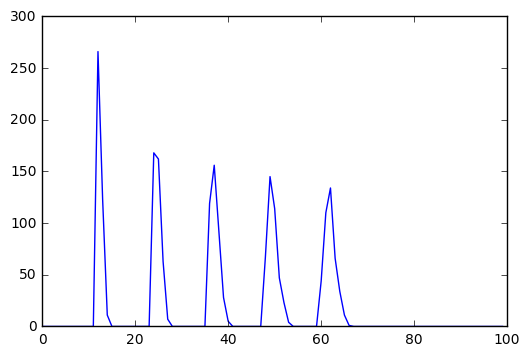

In [70]:
import matplotlib.pyplot as plt

x,y=[],[]
els = sorted(distribution.items(),key=(lambda k:k[0]))


for ex,ey in els:
    x.append(ex)
    y.append(ey)

x,y = np.asarray(x),np.asarray(y)
print(x)
print(y)

plt.plot(x,y)
plt.show()



Nous observons un grand nombre de petites stories (12-13-14 mots) et d'autres stories plus grandes en nombres plus petit et respectivement décroissants.

Après avoir analysé ces données il en ressort que la solution première semble d'être utiliser un réseau neuronal récurrent, en effet nous allons devoir garder un historique des phrases que nous allons lire afin de par la suite répondre à la question ce qui correspond à un réseau neuronal récurrent. Tout le problème est que nous avons deux données à traiter par exemple: des histoires et des questions (sachant que la réponse sera le résultat attendu pour les deux). Une idée est de d'abord séparer le problème en deux en créant un modèle pour les stories et un modèle pour les questions, on pourra ensuite effectuer un traitement différent sur ces derniers et décider de la manière dont nous fusionnerons ces deux réseaux. Pour ce faire nous pouvons utiliser la couche Merge de keras : https://keras.io/layers/core/#merge ce qui nous donnera un unique modèle à base de réseaux récurrents.

Une autre idée serait d'utiliser des "memory networks", ces réseaux récemment décrit dans cet article (https://arxiv.org/abs/1410.3916) semblent adaptés à la résolution de ce problème et en particulier afin de raisonner sur différents élements. Par ailleurs ils ont été créé spécialement pour résoudre ce problème.

Il nous reste donc à déterminer l'architecture des deux modèles que nous allons fusionner afin d'avoir un premier jet.

Nous établissons pour la suite une liste des tâches à faire afin de traiter ce problème (non exhaustive):
- Ecrire un parser pour les données bAbI
- Vectoriser nos exemples (avec un embdedding)
- Déterminer l'architecture optimale du modèle Story
- Déterminer l'architecture optimale du modèle Question
- Déterminer l'architecture optimale du modèle final -> En testant différentes configurations possibles

Par la suite nous pourrons essayer de voir les résultats que nous pourrons avoir avec un memory network.
